In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from shaprpy import explain
from shaprpy.datasets import load_california_housing
import gym
import gym_md
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO, DQN
from md_shap import gen_config, sb3Wrapper,sb3_DQN_wrapper,grid_sb3Wrapper,gen_action_map
from torch.autograd import Variable
from torch import float32
from stable_baselines3.common.policies import obs_as_tensor
import plotly.express as px
import os
# !pip install nbformat

### testing baseline group shaply stuff

In [3]:
from sklearn.ensemble import RandomForestRegressor
from shaprpy import explain
from shaprpy.datasets import load_california_housing

dfx_train, dfx_test, dfy_train, dfy_test = load_california_housing()

dfx_train

## Fit model
model = RandomForestRegressor(verbose=0)
model.fit(dfx_train, dfy_train.values.flatten())

# List to store the explanations
# explanation_list = {}
# explanation_list["sep_lm"] = explain(
#     model=model,
#     x_train=dfx_train,
#     x_explain=dfx_test,
#     approach='regression_separate',
#     prediction_zero=dfy_train.mean().item(),
#     verbose=2,
#     n_batches=1,
#     regression_model='parsnip::linear_reg()'
# )

# # Explain the model using the empirical approach
# explanation_list["empirical"] = explain(
#     model=model,
#     x_train=dfx_train,
#     x_explain=dfx_test,
#     approach='empirical',
#     prediction_zero=dfy_train.mean().item()
# )

## Shapr
df_shapley, pred_explain, internal, timing ,MSEv= explain(
    model = model,
    x_train = dfx_train,
    x_explain = dfx_test,
    approach = 'empirical',
    prediction_zero = dfy_train.mean().item(),
)
print(df_shapley)

group = {'A': ['MedInc','HouseAge','AveRooms'],
         'B': ['AveBedrms','Population','AveOccup'],
         'C': ['Latitude','Longitude']}

df_shapley_g, pred_explain_g, internal_g, timing_g ,msve= explain(
    model = model,
    x_train = dfx_train,
    x_explain = dfx_test,
    approach = 'empirical',
    prediction_zero = dfy_train.mean().item(),
    group = group
)
print(df_shapley_g)
dfy_test
MSEv

R[write to console]: Note: Feature classes extracted from the model contains NA.
Assuming feature classes from the data are correct.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.


R[write to console]: Note: Feature classes extracted from the model contains NA.
Assuming feature classes from the data are correct.


R[write to console]: Setting parameter 'n_batches' to 2 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




       none    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
1  2.205937 -0.621030  0.071411 -0.090193   0.122821   -0.037958 -0.252648   
2  2.205938 -0.488238  0.054341 -0.416954  -0.168696    0.007425  0.141640   
3  2.205938  0.221966  0.518924 -0.115749  -0.178247    0.040083  0.865084   
4  2.205938  0.306283 -0.083123  0.036775   0.108284   -0.151268 -0.152517   
5  2.205938 -0.273460 -0.078941 -0.135768   0.136243    0.102150  0.077141   

   Latitude  Longitude  
1 -0.456652  -0.202960  
2 -0.218640  -0.078545  
3  0.128623   0.263544  
4  0.110140   0.199258  
5  0.062950   0.327928  
       none         A         B         C
1  2.205937 -0.557039 -0.215577 -0.694592
2  2.205938 -1.183290 -0.224834  0.240456
3  2.205938  0.734614  0.553715  0.455900
4  2.205938  0.180575 -0.059259  0.252516
5  2.205938 -0.428395  0.059154  0.587484


{'MSEv':        MSEv   MSEv_sd
 1  0.429018  0.184205,
 'MSEv_explicand':    id      MSEv
 1   1  0.316898
 2   2  0.423245
 3   3  1.127342
 4   4  0.068364
 5   5  0.209242,
 'MSEv_combination':      id_combination               features      MSEv   MSEv_sd
 1                 2                    [1]  0.948622  0.817797
 2                 3                    [2]  1.424628  0.546285
 3                 4                    [3]  1.309840  0.989908
 4                 5                    [4]  1.667279  0.901835
 5                 6                    [5]  1.343349  0.522656
 ..              ...                    ...       ...       ...
 250             251  [1, 2, 3, 4, 6, 7, 8]  0.000262  0.000139
 251             252  [1, 2, 3, 5, 6, 7, 8]  0.001441  0.001370
 252             253  [1, 2, 4, 5, 6, 7, 8]  0.027534  0.016636
 253             254  [1, 3, 4, 5, 6, 7, 8]  0.030001  0.019600
 254             255  [2, 3, 4, 5, 6, 7, 8]  0.268327  0.150317
 
 [254 rows x 4 columns]}

In [42]:
dfx_train, dfx_test, dfy_train, dfy_test = load_california_housing()

## Fit model
class MyNeuralNet(nn.Module):

    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.lin0 = nn.Linear(in_dim, hidden_dim)
        self.lin1 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.lin0(x)
        x = F.relu(x)
        return self.lin1(x).squeeze(-1)

data = TensorDataset(torch.from_numpy(dfx_train.values).float(), torch.from_numpy(dfy_train.values.flatten()).float())
data_loader = DataLoader(data, batch_size=128, shuffle=True)
model = MyNeuralNet(dfx_train.shape[-1], hidden_dim=128)
print(model)
optim = Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    print(f'Training, epoch {epoch+1}...')
    for x, y in data_loader:
        p = model(x)
        loss = F.mse_loss(p, y)
        loss.backward()
        optim.step()
        optim.zero_grad()

## Shapr
df_shapley, pred_explain, internal, timing = explain(
    model = model,
    x_train = dfx_train,
    x_explain = dfx_test,
    approach = 'empirical',
    predict_model = lambda m, x: m(torch.from_numpy(x.values).float()).cpu().detach().numpy(),
    prediction_zero = dfy_train.mean().item(),
)
# print(df_shapley)
print(dfx_train.info())
print(dfy_train)
print(dfy_train.info())
m = model
x = dfx_train.iloc[0]
print(lambda m, x: m(torch.from_numpy(x.values).float()).cpu().detach().numpy())
df_shapley


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




MyNeuralNet(
  (lin0): Linear(in_features=8, out_features=128, bias=True)
  (lin1): Linear(in_features=128, out_features=1, bias=True)
)
Training, epoch 1...
Training, epoch 2...
Training, epoch 3...
Training, epoch 4...
Training, epoch 5...
<rpy2.rinterface.FloatSexpVector object at 0x7f91ad86f9d0> [14]
2
<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 18343 to 15795
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      206 non-null    float64
 1   HouseAge    206 non-null    float64
 2   AveRooms    206 non-null    float64
 3   AveBedrms   206 non-null    float64
 4   Population  206 non-null    float64
 5   AveOccup    206 non-null    float64
 6   Latitude    206 non-null    float64
 7   Longitude   206 non-null    float64
dtypes: float64(8)
memory usage: 22.6 KB
None
       target
18343   4.763
19360   1.341
8680    2.833
18227   2.667
1734    1.138
...       ...
11284   2.292
11964   0.978
5390 

,none,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1,2.205950,4.036109,5.345496,5.743704,4.958375,3.382227,4.545994,3.026637,4.122832
2,2.205950,5.252039,5.702241,4.083750,4.238449,3.199204,5.879998,5.487187,3.703654
3,2.205949,4.840082,4.311369,5.691991,3.347365,3.563894,4.592269,4.825642,4.563850
4,2.205950,4.876310,6.888369,3.091987,4.684311,4.776395,4.889423,4.458900,4.743738
5,2.205950,4.763316,3.401271,3.082360,5.493106,-0.138213,5.627370,3.987965,4.986667


## My groupShap stuff

### Functions

##### Old Model stuff

In [2]:

class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return x
    
def gen_data(config):   
    print('----------Generating Data----------')
    
    # set variables
    data =[]
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']

    if action_type == 'switch':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    elif config['obs_type'] =='grid':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    else:
        env = gym.make(f"md-{lvl}-v0")
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"


    env.setting.IS_ENEMY_POWER_RANDOM =False
    if play_style=='killer':
        env.setting.PLAYER_MAX_HP = 10000

    print(exp)
    if action_type =='base':
        model = PPO.load(f"{path}/{play_style}.zip")  # loading the model from ppo_cartpole.zip 
    elif action_type == 'path':
        model = PPO.load(f"logs/{path}/{exp}/best_model/best_model") 
    elif algo == 'DQN':
        model = DQN.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
    else:
        model = PPO.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
                                                                                     
    curr_obs = env.reset()  
    curr_grid = np.array(env.grid.g)
    # data.append([exp, lvl, 0, -1, env.agent.x, env.agent.y, env.agent.hp, start_grid, play_style, "NO_ACTION",curr_obs, curr_obs, False, 0, dict(env.info),start_grid.shape[0],start_grid.shape[1]])

    for ep in range(5):                                                                    
        for i in range(1000): 
            agent_x = env.agent.x
            agent_y = env.agent.y
            agent_hp = env.agent.hp                                                                  
            action, _state = model.predict(curr_obs, deterministic=True) 
            action = action.tolist()                  
            obs, reward, done, info = env.step(action) 
            grid= np.array(env.grid.g)  
            data.append([exp, lvl, ep,i, agent_x, agent_y, agent_hp, curr_grid,grid, play_style, info['action_taken'],curr_obs, obs, done, reward, dict(info),grid.shape[0],grid.shape[1]])
                                                
            # env.render(mode='human')                                                                        
            if done:                                                                            
                obs = env.reset()
                break

            curr_obs= obs
            curr_grid = grid
                
    return data

def merge_data(data_list, type:str):
    data = None
    if type == 'array':
        # print(data_list[0])
        data = np.asarray(data_list[0],dtype="object")
        for i in range(1,len(data_list)):
            data = np.concatenate((data,np.asarray(data_list[i],dtype="object")))
    elif type == 'dataframe':
        data = pd.concat(data_list,ignore_index=True)
    else:
        assert("data needs to be array or dataframe")
    return data

def prep_data(df):
    obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']
    # need train and test data, train will be used in the train param and test will be used in explain param
    # first get data into right format
    data = df[['curr_obs','action']]
    data[obs_names] = pd.DataFrame(data.curr_obs.tolist(), index= data.index)
    # Split data 
    dfx_train, dfx_test,dfy_train,dfy_test = train_test_split(data[obs_names],data['action'], random_state=42, test_size=5)
    return dfx_train, dfx_test, data

def gen_analysis_data(lvl_list):
    #take in list of levels and the loothrough them
    df_list = []
    df_data_list = []
    df_shap_list= []
    data_list = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            data =gen_data(config)
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            data_list.append(data)
            df_list.append(df)
    
    #TODO add code to merge the data list and df list into one data array and one df
    # merge data 
    game_data = merge_data(data_list, type ="array")
    df_data = merge_data(df_list,type="dataframe")

    # format data
    df_train, df_test ,simp_data= prep_data(df_data)

    #TODO remember to unshuffle data when merging shap to orig data
    return game_data, df_data, df_train, df_test, simp_data

def gen_groupshap_data(lvl_list,df,explainer_type:str):
    # take in data and level list
    # for each level gen config
    df_data = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            algo =config['learning_algo']
            path = config['exp_path']
            #seperate dataframe based on config
            print(config['play_style'])
            df_curr = df.loc[(df['level']== lvl) & (df['play_style']== config['play_style'])]

            # format data
            df_train, df_test ,simp_data= prep_data(df_curr)#TODO need convert back to dataframe alos check why they are not same type as input shap

            #create correct model
            if config['action_type'] == "switch":
                exp = f"{config['action_type']}-{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}_{algo}"
                model_path = f"logs/{path}/{exp}/{config['play_style']}/best_model"
            else:
                exp = f"{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}"
                model_path = f"logs/{path}/{exp}/best_model/best_model"

            if algo =="PPO":
                model = PPO.load(model_path, device='cuda')
            elif config.algo =='DQN':
                model = DQN.load(model_path, device='cuda')
            state_log = np.array(df_curr['curr_obs'].values.tolist())
            # data =torch.FloatTensor(state_log).to('cuda')
            # print(model.policy)
            # print(model.policy.q_net.q_net)
            if config['obs_type']== 'grid':
                model = grid_sb3Wrapper(model)
            elif algo =='PPO':
                model = sb3Wrapper(model)
            elif algo == 'DQN':
                model = sb3_DQN_wrapper(model)
            
            #generate the y data
            f = lambda x: model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32).cuda()).detach().cpu().numpy()
            dfy_train = df_curr['curr_obs'].apply(lambda x: model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().cpu().numpy())
            print(dfy_train)
            print(dfy_train.mean())
            if explainer_type == "kernel":
                df_shapley, pred_explain, internal, timing = explain(
                    model=model,
                    x_train=df_train,
                    x_explain=df_train,
                    approach='emperical',
                    predict_model= lambda x: model.forward(Variable(torch.from_numpy(x.values),requires_grad=False).to(float32)).detach().cpu().numpy(),
                    prediction_zero=dfy_train.mean(),
                    output_size=4
                )
                f = lambda x: model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32).cuda()).detach().cpu().numpy()
            else:
                explainer = shap.DeepExplainer(model, data)
                shap_vals= explainer.shap_values(data,check_additivity=True)
            # make agent model
            # extract correspoding dataframe
            # gen groupshap values for that config
            # add to dataframe

In [4]:
lvl_list =[
    "hard",
    # "check_1",
    # "holmgard_0",
    # "holmgard_1",
    # "holmgard_2",
    # "holmgard_3",
    # "holmgard_4",
    # "holmgard_5",
    # "holmgard_6",
    # "holmgard_7",
    # # # "holmgard_8",
    # "holmgard_9",
]

game_data, df_data, df_train, df_test, simp_data =gen_analysis_data(lvl_list)

----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_switch_switch_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_hard_hard_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'ba

In [5]:
gen_groupshap_data(lvl_list,df_data,"kernel")

switch
0       [-1.4176838, -1.3527068, -2.507051, 4.5917835]
1      [-1.4181141, -1.3475486, -2.5040288, 4.5851736]
2       [-1.3892903, -1.4377325, -2.5450811, 4.675839]
3       [-1.3904492, -1.4365312, -2.5449631, 4.675533]
4       [-1.3923558, -1.434432, -2.5446928, 4.6748605]
                            ...                       
405    [3.080767, -1.3820097, 0.27153894, -0.96458954]
406     [3.080767, -1.3820099, 0.2715389, -0.96458954]
407     [3.080767, -1.3820099, 0.2715389, -0.96458954]
408    [3.080767, -1.3820099, 0.27153888, -0.96458954]
409     [3.080767, -1.3820099, 0.2715389, -0.96458954]
Name: curr_obs, Length: 410, dtype: object
[ 0.7375278 -1.5325549 -1.4994874  2.3702395]


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

##### New model

In [49]:
class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return x
    
def gen_data(config):   
    print('----------Generating Data----------')
    
    # set variables
    data =[]
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']

    if action_type == 'switch':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    elif config['obs_type'] =='grid':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    else:
        env = gym.make(f"md-{lvl}-v0")
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"


    env.setting.IS_ENEMY_POWER_RANDOM =False
    if play_style=='killer':
        env.setting.PLAYER_MAX_HP = 10000

    print(exp)
    if action_type =='base':
        model = PPO.load(f"{path}/{play_style}.zip")  # loading the model from ppo_cartpole.zip 
    elif action_type == 'path':
        model = PPO.load(f"logs/{path}/{exp}/best_model/best_model") 
    elif algo == 'DQN':
        model = DQN.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
    else:
        model = PPO.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
                                                                                     
    curr_obs = env.reset()  
    curr_grid = np.array(env.grid.g)
    # data.append([exp, lvl, 0, -1, env.agent.x, env.agent.y, env.agent.hp, start_grid, play_style, "NO_ACTION",curr_obs, curr_obs, False, 0, dict(env.info),start_grid.shape[0],start_grid.shape[1]])

    for ep in range(5):                                                                    
        for i in range(1000): 
            agent_x = env.agent.x
            agent_y = env.agent.y
            agent_hp = env.agent.hp                                                                  
            action, _state = model.predict(curr_obs, deterministic=True) 
            action = action.tolist()                  
            obs, reward, done, info = env.step(action) 
            grid= np.array(env.grid.g)  
            data.append([exp, lvl, ep,i, agent_x, agent_y, agent_hp, curr_grid,grid, play_style, info['action_taken'],curr_obs, obs, done, reward, dict(info),grid.shape[0],grid.shape[1]])
                                                
            # env.render(mode='human')                                                                        
            if done:                                                                            
                obs = env.reset()
                break

            curr_obs= obs
            curr_grid = grid
                
    return data

def merge_data(data_list, type:str):
    data = None
    if type == 'array':
        # print(data_list[0])
        data = np.asarray(data_list[0],dtype="object")
        for i in range(1,len(data_list)):
            data = np.concatenate((data,np.asarray(data_list[i],dtype="object")))
    elif type == 'dataframe':
        data = pd.concat(data_list,ignore_index=True)
    else:
        assert("data needs to be array or dataframe")
    return data

def prep_data(df):
    obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']
    # need train and test data, train will be used in the train param and test will be used in explain param
    # first get data into right format
    data = df[['curr_obs','action']]
    data[obs_names] = pd.DataFrame(data.curr_obs.tolist(), index= data.index)
    # Split data 
    dfx_train, dfx_test,dfy_train,dfy_test = train_test_split(data[obs_names],data['action'], random_state=42, test_size=5)
    # make dfx_test data
    return dfx_train, dfx_test, data

def gen_analysis_data(lvl_list):
    #take in list of levels and the loothrough them
    df_list = []
    df_data_list = []
    df_shap_list= []
    data_list = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            data =gen_data(config)
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            data_list.append(data)
            df_list.append(df)
    
    #TODO add code to merge the data list and df list into one data array and one df
    # merge data 
    game_data = merge_data(data_list, type ="array")
    df_data = merge_data(df_list,type="dataframe")

    # format data
    df_train, df_test ,simp_data= prep_data(df_data)

    #TODO remember to unshuffle data when merging shap to orig data
    return game_data, df_data, df_train, df_test, simp_data

def gen_groupshap_data(lvl_list,df,explainer_type:str):
    # take in data and level list
    # for each level gen config
    df_shapley_list,pred_explain_list, internal_list, timing_list = [],[],[],[]
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis_new_longer/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            algo =config['learning_algo']
            path = config['exp_path']
            #seperate dataframe based on config
            print(config['play_style'])
            #create temp df for thhe current level and playstyle config from the df parameter
            df_curr = df.loc[(df['level']== lvl) & (df['play_style']== config['play_style'])]
            print(f"---------------------Groupshapley for {lvl}-{config['play_style']}-----------------")
            # format data
            df_train, df_test ,simp_data= prep_data(df_curr)#TODO need convert back to dataframe alos check why they are not same type as input shap

            #create correct model
            if config['action_type'] == "switch":
                exp = f"{config['action_type']}-{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}_{algo}"
                model_path = f"logs/{path}/{exp}/{config['play_style']}/best_model"
            else:
                exp = f"{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}"
                model_path = f"logs/{path}/{exp}/best_model/best_model"

            if algo =="PPO":
                model = PPO.load(model_path, device='cpu')
            elif config.algo =='DQN':
                model = DQN.load(model_path, device='cuda')
            state_log = np.array(df_curr['curr_obs'].values.tolist())
            data =torch.FloatTensor(state_log).to('cpu')

            
            if config['obs_type']== 'grid':
                model = grid_sb3Wrapper(model)
            elif algo =='PPO':
                model = sb3Wrapper(model)
            elif algo == 'DQN':
                model = sb3_DQN_wrapper(model)


            #tensor
            dfy_train = df_curr['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))

            if explainer_type == "kernel":
                df_shapley, pred_explain, internal, timing = explain(
                    model=model,
                    x_train=df_train,
                    x_explain=df_test,
                    approach='independence',
                    predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
                    prediction_zero=dfy_train.mean().item(),
                )
                df_shapley_list.append(df_shapley)
                pred_explain_list.append(pred_explain)
                internal_list.append(internal)
                timing_list.append(timing)
            else:
                explainer = shap.DeepExplainer(model, data)
                shap_vals= explainer.shap_values(data,check_additivity=True)
            # make agent model
            # extract correspoding dataframe
            # gen groupshap values for that config
            # add to dataframe
    return df_shapley_list, pred_explain_list,internal_list,timing_list    

In [50]:
lvl_list =[
    "hard",
    # "check_1",
    # "holmgard_0",
    # "holmgard_1",
    # "holmgard_2",
    # "holmgard_3",
    # "holmgard_4",
    # "holmgard_5",
    # "holmgard_6",
    # "holmgard_7",
    # # # "holmgard_8",
    # "holmgard_9",
]

game_data, df_data, df_train, df_test, simp_data =gen_analysis_data(lvl_list)

----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_switch_switch_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_hard_hard_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'ba

In [30]:
shap_df, pred_data, internal_data, timing_data=gen_groupshap_data(lvl_list,df_data,"kernel")


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




switch
---------------------Groupshapley for hard-switch-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f9190addf50> [14]
2


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




hard
---------------------Groupshapley for hard-hard-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f918a9d25d0> [14]
2


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




treasure
---------------------Groupshapley for hard-treasure-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f918a65fad0> [14]
2


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




killer
---------------------Groupshapley for hard-killer-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f918aad2650> [14]
2


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




potion
---------------------Groupshapley for hard-potion-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f91908949d0> [14]
2


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




runner
---------------------Groupshapley for hard-runner-----------------
<rpy2.rinterface.FloatSexpVector object at 0x7f918a5452d0> [14]
2


In [31]:
print(shap_df)
df_shap = pd.concat(shap_df)

[       none        DM        DT       SDT        DP       SDP        DE  \
1  3.942597  0.064681 -0.013864 -0.009783  0.400184  0.133294 -0.009003   
2  3.942597  0.049591  0.003206  0.003931 -0.530615 -0.077961 -0.003376   
3  3.942597  0.066020 -0.016319 -0.011995  0.400738  0.134778 -0.006258   
4  3.942597  0.070015  0.009359  0.004085  0.384841  0.184723  0.000266   
5  3.942597  0.049566  0.006950  0.004851 -0.532674 -0.099066  0.000809   

        SDE        HP  
1  0.076358 -0.002763  
2 -0.030317 -0.013304  
3  0.077391 -0.001852  
4  0.068673  0.010682  
5 -0.030317  0.001036  ,        none        DM        DT       SDT        DP       SDP        DE  \
1  3.656324 -0.000412 -0.000365  0.325063 -0.000430 -0.004837 -0.004732   
2  3.656324 -0.000412 -0.000365  0.325063 -0.000430 -0.004837 -0.004732   
3  3.656324 -0.000216 -0.000216 -0.807359 -0.000216 -0.000216 -0.000216   
4  3.656324 -0.000593  0.003576  0.271608  0.001022  0.006971  0.008290   
5  3.656324 -0.001071 -0.003

### New and improved groupshap stuff

In [2]:
class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return x

def gen_config(lvl:str, algo:str, obs_type:str, exp_type:str,switch_path:str, base_path:str ='play_style_models/base/', which_model='best'):
    model = None
    if which_model =='latest':
        model = 'best_model'
    else:
        model = 'latest_model_500000_steps'
    config_switch ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'switch',
        'reward_scheme': 'switch',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_hard ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'hard',
        'reward_scheme': 'hard',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_treasure ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'treasure',
        'reward_scheme': 'treasure',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_killer ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'killer',
        'reward_scheme': 'killer',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_potion ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'potion',
        'reward_scheme': 'potion',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_runner ={
        'action_type': 'switch',
        'action_space_type': 'discrete',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'runner',
        'reward_scheme': 'runner',
        'exp_type': f'{exp_type}',
        'learning_algo': f'{algo}',
        'exp_path': f'{switch_path}',
        'base_path': f'{base_path}',
        'which_model': f'{model}',
    }
    config_base_treasure={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'treasure',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'treasure',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
        'base_path': f'{base_path}',
    }
    config_base_killer={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'killer',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'killer',
        'learning_algo':f'{algo}',
        'exp_path': f'{base_path}',
        'base_path': f'{base_path}',
    }
    config_base_potion={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'potion',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'potion',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
        'base_path': f'{base_path}',
    }
    config_base_runner={
        'action_type': 'base',
        'action_space_type': 'box',
        'obs_type': f'{obs_type}',
        'lvl': f'{lvl}',
        'play_style': 'runner',
        'reward_scheme': 'fiftytwoFifty',
        'exp_type': 'runner',
        'learning_algo': f'{algo}',
        'exp_path': f'{base_path}',
        'base_path': f'{base_path}',
    }

    return [config_switch, config_hard,config_treasure,config_killer, config_potion, config_runner, config_base_treasure, config_base_killer, config_base_potion, config_base_runner]

def gen_data(config):   
    print('----------Generating Data----------')
    
    # set variables
    data =[]
    action_type = config['action_type']
    exp_type =config['exp_type']
    lvl = config['lvl']
    play_style= config['play_style']
    reward_scheme=config['reward_scheme']
    algo= config['learning_algo']
    path = config['exp_path']
    which_model = config['which_model'] #TODO added which model

    if action_type == 'switch':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    elif config['obs_type'] =='grid':
        exp = f"{action_type}-{lvl}_{play_style}_{reward_scheme}_{exp_type}_{algo}"
        env = gym.make(f"md-switch-{lvl}-v0",config=config)
    else:
        env = gym.make(f"md-{lvl}-v0")
        exp = f"{lvl}_{play_style}_{reward_scheme}_{exp_type}"


    env.setting.IS_ENEMY_POWER_RANDOM =False
    if play_style=='killer':
        print('setting player HP')
        env.setting.PLAYER_MAX_HP = 100

    print(exp)
    if action_type =='base':
        model = PPO.load(f"{path}/{play_style}.zip")  # loading the model from ppo_cartpole.zip 
    elif action_type == 'path':
        model = PPO.load(f"logs/{path}/{exp}/best_model/best_model") 
    elif algo == 'DQN':
        model = DQN.load(f"logs/{path}/{exp}/{play_style}/best_model")  # loading the model from ppo_cartpole.zip 
    else:
        model = PPO.load(f"logs/{path}/{exp}/{play_style}/{which_model}")  # loading the model from ppo_cartpole.zip  #TODO added which model
                                                                                     
    curr_obs = env.reset()  
    curr_grid = np.array(env.grid.g)
    # data.append([exp, lvl, 0, -1, env.agent.x, env.agent.y, env.agent.hp, start_grid, play_style, "NO_ACTION",curr_obs, curr_obs, False, 0, dict(env.info),start_grid.shape[0],start_grid.shape[1]])

    for ep in range(5):                                                                    
        for i in range(1000): 
            agent_x = env.agent.x
            agent_y = env.agent.y
            agent_hp = env.agent.hp
            action, _state = model.predict(curr_obs, deterministic=True) 
            action = action.tolist()                  
            obs, reward, done, info = env.step(action) 
            grid= np.array(env.grid.g)  
            data.append([exp, lvl, ep,i, agent_x, agent_y, agent_hp, curr_grid,grid, play_style, info['action_taken'],curr_obs, obs, done, reward, dict(info),grid.shape[0],grid.shape[1]])
                                                
            # env.render(mode='human')                                                                        
            if done:                                                                            
                obs = env.reset()
                break

            curr_obs= obs
            curr_grid = grid
                
    return data, model #TODO added model

def merge_data(data_list, type:str):
    data = None
    if type == 'array':
        # print(data_list[0])
        data = np.asarray(data_list[0],dtype="object")
        for i in range(1,len(data_list)):
            data = np.concatenate((data,np.asarray(data_list[i],dtype="object")))
    elif type == 'dataframe':
        data = pd.concat(data_list,ignore_index=True)
    else:
        assert("data needs to be array or dataframe")
    return data

def prep_data(df):
    obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']
    # need train and test data, train will be used in the train param and test will be used in explain param
    # first get data into right format
    # print(df.tail())
    # df_curr = df.loc[(df['run']==1)]
    # print(df.head())
    # data = df_cu[['curr_obs','action']]
    
    df[obs_names] = pd.DataFrame(df.curr_obs.tolist(), index= df.index)
    # Split data 
    data = df
    dfx_train, dfx_test,dfy_train,dfy_test = train_test_split(data[obs_names],data['action'], random_state=42, test_size=5,shuffle=False)
    dfx_test = dfx_train.loc[(df['run']==0)]
    # data = df_curr[['curr_obs','action']]
    # df_curr = df.loc[(df['run']==1)]
    # make dfx_test data  only 1 run 
    
    return dfx_train[obs_names], dfx_test[obs_names], data

def gen_analysis_data(lvl_list, config):#TODO added config param
    #take in list of levels and the loothrough them
    df_list = []
    df_data_list = []
    df_shap_list= []
    data_list = []
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            data, model =gen_data(config) #TODO added model
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            data_list.append(data)
            df_list.append(df)
    
    #TODO add code to merge the data list and df list into one data array and one df
    # merge data 
    game_data = merge_data(data_list, type ="array")
    df_data = merge_data(df_list,type="dataframe")

    # format data
    df_train, df_test ,simp_data= prep_data(df_data)

    #TODO remember to unshuffle data when merging shap to orig data
    return game_data, df_data, df_train, df_test, simp_data

def gen_groupshap_data(lvl_list,df,explainer_type:str): #TODO fix this shit
    # take in data and level list
    # for each level gen config
    df_shapley_list,pred_explain_list, internal_list, timing_list = [],[],[],[]
    for lvl in lvl_list:
        configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis",switch_path="switching_analysis_new_longer/",base_path="./play_style_models/base/")
        for config in configs[0:6]:
            algo =config['learning_algo']
            path = config['exp_path']
            #seperate dataframe based on config
            print(config['play_style'])
            #create temp df for thhe current level and playstyle config from the df parameter
            df_curr = df.loc[(df['level']== lvl) & (df['play_style']== config['play_style'])]
            print(f"---------------------Groupshapley for {lvl}-{config['play_style']}-----------------")
            # format data
            df_train, df_test ,simp_data= prep_data(df_curr)#TODO need convert back to dataframe alos check why they are not same type as input shap

            #create correct model
            if config['action_type'] == "switch":
                exp = f"{config['action_type']}-{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}_{algo}"
                model_path = f"logs/{path}/{exp}/{config['play_style']}/best_model"
            else:
                exp = f"{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}"
                model_path = f"logs/{path}/{exp}/best_model/best_model"

            if algo =="PPO":
                model = PPO.load(model_path, device='cpu')
            elif config.algo =='DQN':
                model = DQN.load(model_path, device='cuda')
            state_log = np.array(df_curr['curr_obs'].values.tolist())
            data =torch.FloatTensor(state_log).to('cpu')

            
            if config['obs_type']== 'grid':
                model = grid_sb3Wrapper(model)
            elif algo =='PPO':
                model = sb3Wrapper(model)
            elif algo == 'DQN':
                model = sb3_DQN_wrapper(model)


            #tensor
            dfy_train = df_curr['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))
            print(dfy_train)
            if explainer_type == "kernel":
                df_shapley, pred_explain, internal, timing = explain(
                    model=model,
                    x_train=df_train,
                    x_explain=df_test,
                    approach='independence',
                    predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
                    prediction_zero=dfy_train.mean().item(),
                )
                df_shapley_list.append(df_shapley)
                pred_explain_list.append(pred_explain)
                internal_list.append(internal)
                timing_list.append(timing)
            else:
                explainer = shap.DeepExplainer(model, data)
                shap_vals= explainer.shap_values(data,check_additivity=True)
            # make agent model
            # extract correspoding dataframe
            # gen groupshap values for that config
            # add to dataframe
    return df_shapley_list, pred_explain_list,internal_list,timing_list

def groupShap(lvl_list,base_config,approach= 'independence', group= None):
    # init lists
    df_shapley_list,pred_explain_list, internal_list, timing_list = [],[],[],[]
    for lvl in lvl_list:
        #gen configs
        configs = gen_config(lvl=lvl,algo=base_config['algo'],obs_type=base_config['obs_type'],exp_type=base_config['exp_type'],base_path= base_config['base_path'],which_model=base_config['which_model'])
        for config in configs[0:6]:
            data, model = gen_data(config)
            algo =config['learning_algo']
            # prep data
            df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
            #TODO remember to do the todo in prep data
            df_train, df_test ,simp_data= prep_data(df)#TODO need convert back to dataframe alos check why they are not same type as input shap
            # wrap model
            if config['obs_type']== 'grid':
                model = grid_sb3Wrapper(model)
            elif algo =='PPO':
                model = sb3Wrapper(model)
            elif algo == 'DQN':
                model = sb3_DQN_wrapper(model)
            
            dfy_train = df['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))
            print(dfy_train)
            
            # generate groupshap data
            df_shapley, pred_explain, internal, timing = explain(
                model=model,
                x_train=df_train,
                x_explain=df_test,
                approach=approach,
                predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
                prediction_zero=dfy_train.mean().item(),
                group=group,
            )
            # add all data list
            df_shapley_list.append(df_shapley)
            pred_explain_list.append(pred_explain)
            internal_list.append(internal)
            timing_list.append(timing)
            

    return df_shapley_list, pred_explain_list,internal_list,timing_list

def group_shap_single_exp(config,approach= 'independence', group= None):
    #TODO look into generating on a per action basis - definetly do this
    data, model = gen_data(config)
    algo =config['learning_algo']
    # prep data
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    #TODO remember to do the todo in prep data
    df_train, df_test ,simp_data= prep_data(df)#TODO need convert back to dataframe alos check why they are not same type as input shap
    # wrap model
    if config['obs_type']== 'grid':
        model = grid_sb3Wrapper(model)
    elif algo =='PPO':
        model = sb3Wrapper(model)
    elif algo == 'DQN':
        model = sb3_DQN_wrapper(model)
    
    dfy_train = df['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))
    print(dfy_train)
    
    # generate groupshap data
    df_shapley, pred_explain, internal, timing, MSEv = explain(
        model=model,
        x_train=df_train,
        x_explain=df_test,
        approach=approach,
        predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
        prediction_zero=dfy_train.mean().item(),
        # MSEv_uniform_comb_weights=False,
        group=group,
    )
    return df_shapley, pred_explain, internal, timing, MSEv, df

def match_check(max, action):
    if (max == 'DT' or max =='SDT') and (action=='TREASURE'):
        return 1
    elif(max == 'DP' or max =='SDP' or max == 'HP') and (action=='POTION'):#TODO look into HP being moved or even into its own if statement max is hp and act =(P or K)
        return 1
    elif(max == 'DE' or max =='SDE') and (action=='RUNNER'):
        return 1
    elif(max == 'DM' or max == 'HP') and (action=='KILLER'):
        return 1
    else:
        return 0
    
def match_check_play_style(max, action):
    if (max == ('Treasure')) and (action=='TREASURE'):
        return 1
    elif(max == ("Health")) and (action=='POTION'):
        return 1
    elif(max == ('Exit')) and (action=='RUNNER'):
        return 1
    elif(max == ('Monster')) and (action=='KILLER'):
        return 1
    else:
        return 0

def groupShap_quant_results(df_shapley, df, MSEv,timing, approach, grouping):
    if grouping == 'play-style':
        temp =df['action'].loc[(df['run']==0)]
        df_shapley['Max'] = df_shapley[["Treasure","Exit","Health","Monster"]].idxmax(axis=1)
        df_shapley['Max_abs'] = df_shapley[["Treasure","Exit","Health","Monster"]].abs().idxmax(axis=1)
        df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1) #append all actions to the shap 
        # count matches for every state
        df_shapley['match'] = df_shapley.apply(lambda row: match_check_play_style(row.Max,row.action),axis=1)
        df_shapley['match_abs'] = df_shapley.apply(lambda row: match_check_play_style(row.Max_abs,row.action),axis=1)
        # count matches when on object
        temp =df['curr_obs'].loc[(df['run']==0)]
        df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1)
        df_obj_shapley = df_shapley[[0 in l for l in df_shapley['curr_obs']]]
        # Create summary data frame for the level
        print(df['experiment'].iloc[0],df['level'].iloc[0])
        df_summary = pd.DataFrame(data =[[df['experiment'].iloc[0],df['level'].iloc[0], approach,grouping]],columns=['exp_id','level','approach','grouping'])
        df_summary['MSEv'] = MSEv["MSEv"]['MSEv'].iloc[0]
        df_summary['MSEv_std'] = MSEv["MSEv"]['MSEv_sd'].iloc[0]
        df_summary['total_time_secs'] = timing["total_time_secs"] #total time
        df_summary['setup']= timing["timing_secs"]['setup']
        df_summary['test_prediction']= timing["timing_secs"]['test_prediction']
        df_summary['compute_vS'] = timing["timing_secs"]['compute_vS']
        df_summary['shapley_computation']= timing["timing_secs"]['shapley_computation']
        # Match calc
        df_summary['match_avg'] = df_shapley['match'].sum()/df_shapley['match'].count()
        df_summary['match_abs_avg'] = df_shapley['match_abs'].sum()/df_shapley['match_abs'].count()
        df_summary['match_obj_avg'] = df_obj_shapley['match'].sum()/df_obj_shapley['match'].count()
        df_summary['match_obj_abs_avg'] = df_obj_shapley['match_abs'].sum()/df_obj_shapley['match_abs'].count()
        

        return df_summary
    else:
        temp =df['action'].loc[(df['run']==0)]
        df_shapley['Max'] = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].idxmax(axis=1)
        df_shapley['Max_abs'] = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].abs().idxmax(axis=1)
        df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1) #append all actions to the shap 
        # count matches for every state
        df_shapley['match'] = df_shapley.apply(lambda row: match_check(row.Max,row.action),axis=1)
        df_shapley['match_abs'] = df_shapley.apply(lambda row: match_check(row.Max_abs,row.action),axis=1)
        # count matches when on object
        temp =df['curr_obs'].loc[(df['run']==0)]
        df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1)
        df_obj_shapley = df_shapley[[0 in l for l in df_shapley['curr_obs']]]
        # Create summary data frame for the level
        print(df['experiment'].iloc[0],df['level'].iloc[0])
        df_summary = pd.DataFrame(data =[[df['experiment'].iloc[0],df['level'].iloc[0], approach,grouping]],columns=['exp_id','level','approach','grouping'])
        df_summary['MSEv'] = MSEv["MSEv"]['MSEv'].iloc[0]
        df_summary['MSEv_std'] = MSEv["MSEv"]['MSEv_sd'].iloc[0]
        df_summary['total_time_secs'] = timing["total_time_secs"] #total time
        df_summary['setup']= timing["timing_secs"]['setup']
        df_summary['test_prediction']= timing["timing_secs"]['test_prediction']
        df_summary['compute_vS'] = timing["timing_secs"]['compute_vS']
        df_summary['shapley_computation']= timing["timing_secs"]['shapley_computation']
        # Match calc
        df_summary['match_avg'] = df_shapley['match'].sum()/df_shapley['match'].count()
        df_summary['match_abs_avg'] = df_shapley['match_abs'].sum()/df_shapley['match_abs'].count()
        df_summary['match_obj_avg'] = df_obj_shapley['match'].sum()/df_obj_shapley['match'].count()
        df_summary['match_obj_abs_avg'] = df_obj_shapley['match_abs'].sum()/df_obj_shapley['match_abs'].count()
        

        return df_summary

def group_shap_resluts_to_csv(df_shapley, df, timing, MSEv, approach,grouping,csv):
    #gen exp id
    #shapley_csv
    df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach=approach,grouping= grouping)
    if os.path.exists(csv):
        df_summary.to_csv(csv,mode='a',header=False,index=False)
    else:
        df_summary.to_csv(csv,index=False)

def group_shap_single_exp_better(config,approach= 'independence', grouping= None):
    #TODO look into generating on a per action basis - definetly do this
    data, model = gen_data(config)
    algo =config['learning_algo']

    # wrap model
    if config['obs_type']== 'grid':
        model = grid_sb3Wrapper(model)
    elif algo =='PPO':
        model = sb3Wrapper(model)
    elif algo == 'DQN':
        model = sb3_DQN_wrapper(model)
        
    # prep data
    df = pd.DataFrame(data, columns=['experiment','level','run','step','x','y','hp','curr_grid','grid','play_style','action','curr_obs','observation','done','reward','info','grid_rows','grid_columns'])
    #TODO remember to do the todo in prep data

    # Separate DataFrame by 'action' column and apply the custom function
    dfs =[]
    pred_explain = [],
    for action, group in df.groupby('action'):
        # print(group.info())
        # dfs[action] = groupshap(group)
        # print(group)
        df_train, df_test ,simp_data= prep_data(group)#TODO need convert back to dataframe alos check why they are not same type as input shap
        
        dfy_train = group['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))

        print(dfy_train)
        # print(len(df_test))

        
        # generate groupshap data
        df_shapley, pred_explain, internal, timing, MSEv_score = explain(
            model=model,
            x_train=df_train,
            x_explain=df_test,
            approach=approach,
            predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
            prediction_zero=dfy_train.mean().item(),
            group=grouping,
        )
        df_shapley.index =df_test.index
        dfs.append(df_shapley)
        # Merge updated DataFrames back together without ignoring indexes
    # print(dfs)
    merged_df = pd.concat(dfs,join='outer')
    merged_df.sort_index(inplace=True)

    return df_shapley, pred_explain, internal, timing, merged_df

### Single exp

In [3]:
base_config={
    'lvl': 'policy_3',
    'obs_type': "distance",
    'learning_algo': "PPO",
    'exp_type': "switch_analysis_new",
    'action_type': 'switch',
    'action_space_type': 'discrete',
    'play_style': 'switch',
    'reward_scheme': 'switch',
    'learning_algo': 'PPO',
    'exp_path': 'switching_analysis_new_hp',
    'base_path': 'play_style_models/base/',
    'which_model': 'best_model',
    # 'which_model': 'latest_model_500000_steps',
}
df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config)

----------Generating Data----------
{'lvl': 'policy_3', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'switch_analysis_new', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'switching_analysis_new_hp', 'base_path': 'play_style_models/base/', 'which_model': 'latest_model_500000_steps'}
switch-policy_3_switch_switch_switch_analysis_new_PPO
0       [4.529238]
1      [4.5305057]
2      [4.5270247]
3       [4.514914]
4       [4.490382]
          ...     
155    [3.0130048]
156    [3.0130048]
157    [3.0130048]
158    [3.0130048]
159    [3.0130048]
Name: curr_obs, Length: 160, dtype: object


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




In [9]:
# df_shapley
# pred_explain
# internal
# timing
df.head()

,experiment,level,run,step,x,y,hp,curr_grid,grid,play_style,...,grid_rows,grid_columns,DM,DT,SDT,DP,SDP,DE,SDE,HP
0,switch-holmgard_2_switch_switch_switch_analysi...,holmgard_2,0,0,1,10,40,"[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...","[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...",switch,...,12,12,4,13,1000,9,1000,21,1000,40
1,switch-holmgard_2_switch_switch_switch_analysi...,holmgard_2,0,1,2,10,40,"[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...","[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...",switch,...,12,12,3,12,1000,8,1000,20,1000,40
2,switch-holmgard_2_switch_switch_switch_analysi...,holmgard_2,0,2,2,9,40,"[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...","[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...",switch,...,12,12,2,11,1000,7,1000,19,1000,40
3,switch-holmgard_2_switch_switch_switch_analysi...,holmgard_2,0,3,2,8,40,"[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...","[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...",switch,...,12,12,1,10,1000,6,1000,18,1000,40
4,switch-holmgard_2_switch_switch_switch_analysi...,holmgard_2,0,4,3,8,30,"[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...","[[1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, ...",switch,...,12,12,0,9,9,5,5,17,19,30


In [5]:
# print(df[['curr_obs','action']])
# print(df['action'].unique())
# sns.lineplot(data=df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]], linewidth=2.5, palette="tab10")
fig =px.line(data_frame=df[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]],x= df[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].index ,y = df[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].columns).update_layout(xaxis_title="Step", yaxis_title="Shap Value")
fig.show()


In [39]:
base_config_policy_2={
    'lvl': 'policy_2',
    'obs_type': "distance",
    'learning_algo': "PPO",
    'exp_type': "switch_exitLessBetter",
    'action_type': 'switch',
    'action_space_type': 'discrete',
    'play_style': 'switch',
    'reward_scheme': 'switch',
    'learning_algo': 'PPO',
    'exp_path': 'switching',
    'base_path': 'play_style_models/base/',
    'which_model': 'best_model',
    # 'which_model': 'latest_model_500000_steps',
}
base_config={
    'lvl': 'policy_8',
    'obs_type': "distance",
    'learning_algo': "PPO",
    'exp_type': "groupShap_policy_test_256",
    'action_type': 'switch',
    'action_space_type': 'discrete',
    'play_style': 'switch',
    'reward_scheme': 'switch',
    'learning_algo': 'PPO',
    # 'exp_path': 'switching_analysis_new_hp',
    'exp_path': 'groupShap_test',
    'base_path': 'play_style_models/base/',
    'which_model': 'best_model',
    # 'which_model': 'latest_model_1000000_steps',
}
# df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config)
# print(df['action'].unique())
# fig =px.line(data_frame=df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].abs(),
#              x= df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].index ,
#              y = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].columns,
#              title =f"{base_config["lvl"]} | switching agent | independence | no group |  ( MSEv = {MSEv["MSEv"]['MSEv'].iloc[0]} | time(sec) = {timing["total_time_secs"]})"
#              ).update_layout(xaxis_title="Step", yaxis_title="Shap Value (abs)")
# fig.show()
# MSEv["MSEv"]
# img =gen_action_map(df,f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.jpg')
# plt.imshow(img)
# # timing
# df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach='independence',grouping= None)
# group_shap_resluts_to_csv(df_shapley,df,timing,MSEv,approach='independence',grouping= None,csv="groupShap_analysis/data/level_groupShap_summary.csv")

# df_summary

#### independece

----------Generating Data----------
{'lvl': 'policy_8', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'groupShap_policy_test_256', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'groupShap_test', 'base_path': 'play_style_models/base/', 'which_model': 'best_model'}
switch-policy_8_switch_switch_groupShap_policy_test_256_PPO


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




0     [3.4390152]
1     [4.3898497]
2     [4.5002565]
3      [4.350561]
4     [3.9559822]
5     [4.9885883]
6      [5.270291]
7      [5.270291]
8      [4.546127]
9       [5.33661]
10    [5.5010586]
11    [5.5010586]
12     [4.546127]
13      [5.33661]
14    [5.5010586]
15    [5.5010586]
16     [4.546127]
17      [5.33661]
18    [5.5010586]
19    [5.5010586]
20     [4.546127]
21      [5.33661]
22    [5.5010586]
Name: curr_obs, dtype: object
['TREASURE' 'RUNNER']


switch-policy_8_switch_switch_groupShap_policy_test_256_PPO policy_8


,exp_id,level,approach,grouping,MSEv,MSEv_std,total_time_secs,setup,test_prediction,compute_vS,shapley_computation,match_avg,match_abs_avg,match_obj_avg,match_obj_abs_avg
0,switch-policy_8_switch_switch_groupShap_policy...,policy_8,independence,None,0.03538,0.012359,1.385342,0.019076,0.001348,1.348355,0.016563,0.428571,0.714286,0.0,1.0


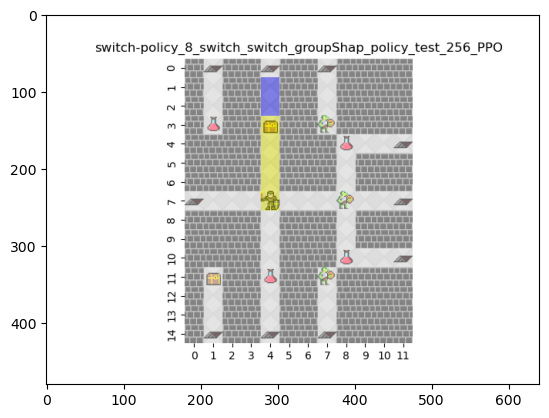

In [40]:
df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config,approach='empirical')
print(df['action'].unique())
fig =px.line(data_frame=df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].abs(),
             x= df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].index ,
             y = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].columns,
             title =f"{base_config["lvl"]} | switching agent | independence | no group |  ( MSEv = {MSEv["MSEv"]['MSEv'].iloc[0]} | time(sec) = {timing["total_time_secs"]})"
             ).update_layout(xaxis_title="Step", yaxis_title="Shap Value (abs)")
fig.show()
MSEv["MSEv"]
img =gen_action_map(df.loc[(df['run']==0)],f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.png')
# img =gen_action_map(df.loc[(df['run']==0)],f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.jpg')

plt.imshow(img)
# timing
df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach='independence',grouping= None)
# group_shap_resluts_to_csv(df_shapley,df,timing,MSEv,approach='independence',grouping= None,csv="groupShap_analysis/data/level_groupShap_summary_new.csv")

df_summary

#### Empirical | No group

----------Generating Data----------
{'lvl': 'policy_6', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'groupShap_test_1', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'groupShap_test', 'base_path': 'play_style_models/base/', 'which_model': 'best_model'}
switch-policy_6_switch_switch_groupShap_test_1_PPO


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




0       [3.6348264]
1        [3.572431]
2       [3.4087949]
3       [3.0513945]
4       [2.6039398]
           ...     
135     [0.6846249]
136    [0.71788216]
137    [0.77279633]
138     [0.9457787]
139     [1.1224713]
Name: curr_obs, Length: 140, dtype: object
['TREASURE' 'KILLER' 'POTION' 'RUNNER']


[ WARN:0@402.171] global loadsave.cpp:248 findDecoder imread_('./README/resources/md_stages_screenshots/md-policy_6-v0_step0.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


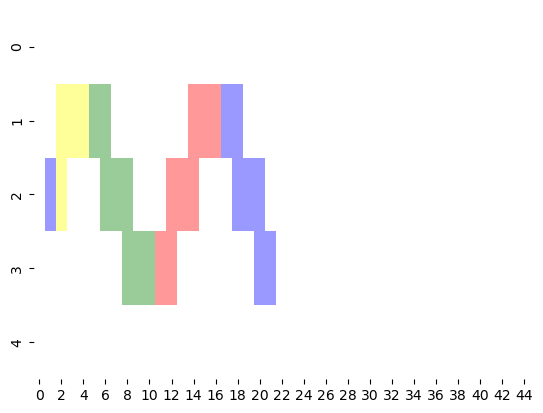

In [12]:
df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config,approach='empirical')
print(df['action'].unique())
fig =px.line(data_frame=df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].abs(),
             x= df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].index ,
             y = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].columns,
             title =f"{base_config["lvl"]} | switching agent | empirical | no group |  ( MSEv = {MSEv["MSEv"]['MSEv'].iloc[0]} | time(sec) = {timing["total_time_secs"]})"
             ).update_layout(xaxis_title="Step", yaxis_title="Shap Value (abs)")
fig.show()
MSEv["MSEv"]
img =gen_action_map(df,f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.jpg')
plt.imshow(img)

df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach='empirical',grouping= None)
# group_shap_resluts_to_csv(df_shapley,df,timing,MSEv,approach='empirical',grouping= None,csv="groupShap_analysis/data/level_groupShap_summary.csv")
# df.loc[(df['run']==0)]
# df['action'].loc[(df['run']==0)]

# df_shapley.reset_index()

#TODO add stat stuff
# df_shapley
df_summary

#### Emirical | group = play-style

In [38]:
object_group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Potion': ['DP','SDP'],
    'Monster': ['DM'],
    'HP': ['HP']
}
group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Health': ['DP','SDP'],
    'Monster':['DM']
}
basic_group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Health': ['DP','SDP','HP','DM'],
    # 'Monster':['DM']
}
safety_group = {
    'Treasure':['DT'],
    'Exit': ['DE'],
    'Potion': ['DP'],
    'Safe': ['SDT','SDP','SDE','HP'],
    'Monster':['DM']
}
df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config,approach='empirical',group= group)
print(df['action'].unique())
#TODO look how to exclude non column
df_shapley.drop(columns = 'none',inplace=True)
fig =px.line(data_frame=df_shapley,
             x= df_shapley.index ,
             y = df_shapley.columns,
             title =f"{base_config["lvl"]} | switching agent | empirical | play-style group |  ( MSEv = {MSEv["MSEv"]['MSEv'].iloc[0]} | time(sec) = {timing["total_time_secs"]})"
             ).update_layout(xaxis_title="Step", yaxis_title="Shap Value (abs)")
fig.show()
MSEv['MSEv']
img =gen_action_map(df,f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.jpg')
plt.imshow(img)

df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach='empirical',grouping= 'play-style')
# group_shap_resluts_to_csv(df_shapley,df,timing,MSEv,approach='empirical',grouping= "play-style",csv="groupShap_analysis/data/level_groupShap_summary.csv")

df_summary

----------Generating Data----------
{'lvl': 'strand_2', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'switch_analysis_new', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'switching_analysis_new_hp', 'base_path': 'play_style_models/base/', 'which_model': 'latest_model_500000_steps'}
switch-strand_2_switch_switch_switch_analysis_new_PPO


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Error in check_groups(feature_names, group) : 
  The data feature(s) HP do not
belong to one of the groups. Add to a group.



0        [4.374073]
1        [4.459479]
2       [4.4202547]
3       [4.4394565]
4       [4.4886518]
           ...     
455     [2.7829485]
456      [2.542296]
457     [1.8365356]
458    [0.93481016]
459     [1.1645132]
Name: curr_obs, Length: 460, dtype: object


RRuntimeError: Error in check_groups(feature_names, group) : 
  The data feature(s) HP do not
belong to one of the groups. Add to a group.


In [10]:
groupShap_summary_df = pd.read_csv("groupShap_analysis/data/level_groupShap_summary.csv",nrows=39)

groupShap_summary_df[['level','approach','grouping','MSEv','match_avg', 'match_abs_avg', 'match_obj_avg','match_obj_abs_avg']].describe()

#independence df
gshap_ind = groupShap_summary_df.loc[(groupShap_summary_df['approach'] == 'independence')]
gshap_ind.describe()

# # emp no group df
gshap_emp = groupShap_summary_df.loc[(groupShap_summary_df['approach'] == 'empirical') & (groupShap_summary_df['grouping'] != 'play-style')]
gshap_emp.describe()

gshap_empg = groupShap_summary_df.loc[(groupShap_summary_df['approach'] == 'empirical') & (groupShap_summary_df['grouping'] == 'play-style')]
gshap_empg.describe()

,MSEv,MSEv_std,total_time_secs,setup,test_prediction,compute_vS,shapley_computation,match_avg,match_abs_avg,match_obj_avg,match_obj_abs_avg
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.305134,0.040310,2.987389,0.024999,0.001175,2.951977,0.009239,0.473950,0.470615,0.612831,0.604726
std,0.182549,0.018722,1.573976,0.003841,0.000214,1.577824,0.004911,0.239307,0.161220,0.273432,0.256071
min,0.031710,0.005464,1.018637,0.019861,0.000894,0.973270,0.004815,0.000000,0.000000,0.000000,0.000000
25%,0.164248,0.023949,1.865850,0.023219,0.000942,1.826596,0.006227,0.326923,0.391850,0.439746,0.445560
50%,0.332360,0.047560,2.420844,0.023666,0.001225,2.384842,0.006775,0.428750,0.484266,0.662879,0.550505
75%,0.420774,0.055062,4.641144,0.027037,0.001335,4.610112,0.012487,0.625000,0.586890,0.800000,0.800000
max,0.581377,0.063273,5.377284,0.033353,0.001496,5.347304,0.019847,0.899281,0.666667,0.977273,1.000000


Text(0.5, 1.0, 'Average Compute Time')

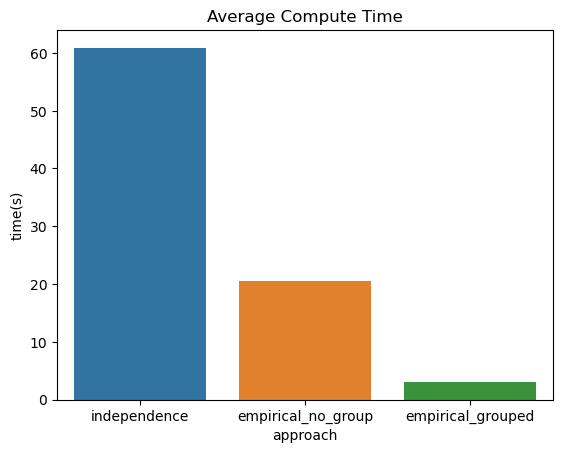

In [16]:
comp_df = pd.DataFrame(data=[['independence',60.926654,0.766432],['empirical_no_group',20.44129,0.185153],['empirical_grouped',3.02114,0.305134]],
                       columns=['approach','time(s)','MSEv'])
sns.barplot(comp_df, x='approach',y='time(s)').set_title('Average Compute Time')
# comp_df

Text(0.5, 1.0, 'Average of occurences the Shapley Value Matched\nwith Chosen Behaviour per Object Collection')

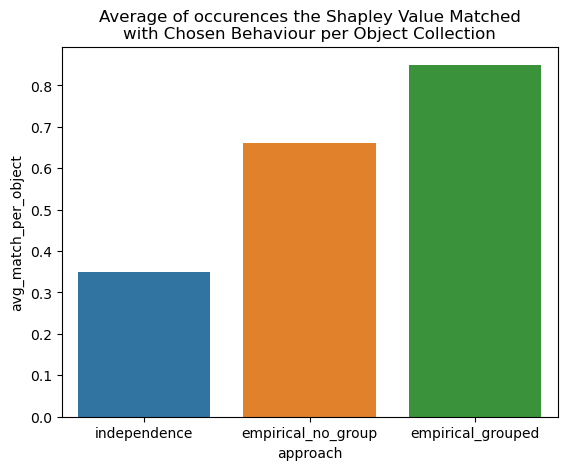

In [24]:
match_df = pd.DataFrame(data=[['independence',0.3,0.35],['empirical_no_group',0.47,0.66],['empirical_grouped',0.65,0.85]],
                       columns=['approach','avg_match_per_state','avg_match_per_object'])
sns.barplot(match_df, x='approach',y='avg_match_per_object').set_title('Average of occurences the Shapley Value Matched\nwith Chosen Behaviour per Object Collection')

In [13]:
# checking how to isolate feature stuff
# MSEv["MSEv"]['MSEv'].iloc[0]
MSEv["MSEv"]
print("MSEv stuff")
print(MSEv["MSEv"]['MSEv'].iloc[0]) #MSEv
print(MSEv["MSEv"]['MSEv_sd'].iloc[0]) #MSEv_sd

print("\ntiming stuff")
print(timing["total_time_secs"]) #total time
print(timing["timing_secs"]['setup'])
print(timing["timing_secs"]['test_prediction'])
print(timing["timing_secs"]['compute_vS'])
print(timing["timing_secs"]['shapley_computation'])

# def melt_dict(dic):
#     re = {}
#     for k,v in dic.items():
#         if isinstance(v,dict):
#             re.update(v)
#         else:
#             re.update({k:v})
#     return re

# new_timing =melt_dict(timing)
# test_df = pd.concat([df_shapley,pd.DataFrame.from_dict(new_timing)])
# test_df
def match_check(max, action):
    if (max == ('DT'or max =='SDT')) and (action=='TREASURE'):
        return 1
    elif(max == 'DP' or max =='SDP' or max == 'HP') and (action=='POTION'):
        return 1
    elif(max == ('DE'or max =='SDE')) and (action=='RUNNER'):
        return 1
    elif(max == ('DM')) and (action=='KILLER'):
        return 1
    else:
        return 0
    
def match_check_on_obj(max, action):
    if (max == ('DT'or 'SDT')) and (action=='TREASURE'):
        return 1
    elif(max == ('DP'or'SDP')) and (action=='POTION'):
        return 1
    elif(max == ('DE'or 'SDE')) and (action=='RUNNER'):
        return 1
    elif(max == ('DM')) and (action=='KILLER'):
        return 1
    else:
        return 0

def groupShap_quant_results(df_shapley, df, MSEv,timing, approach, grouping):
    
    temp =df['action'].loc[(df['run']==0)]
    df_shapley['Max'] = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].idxmax(axis=1)
    df_shapley['Max_abs'] = df_shapley[["DM","DT","SDT","DP","SDP","DE","SDE","HP"]].abs().idxmax(axis=1)
    df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1) #append all actions to the shap 
    # count matches for every state
    df_shapley['match'] = df_shapley.apply(lambda row: match_check(row.Max,row.action),axis=1)
    df_shapley['match_abs'] = df_shapley.apply(lambda row: match_check(row.Max_abs,row.action),axis=1)
    # count matches when on object
    temp =df['curr_obs'].loc[(df['run']==0)]
    df_shapley = pd.concat([df_shapley.reset_index(),temp],axis =1)
    df_obj_shapley = df_shapley[[0 in l for l in df_shapley['curr_obs']]]
    # Create summary data frame for the level
    print(df['experiment'].iloc[0],df['level'].iloc[0])
    df_summary = pd.DataFrame(data =[[df['experiment'].iloc[0],df['level'].iloc[0], approach,grouping]],columns=['exp_id','level','approach','grouping'])
    df_summary['MSEv'] = MSEv["MSEv"]['MSEv'].iloc[0]
    df_summary['MSEv_std'] = MSEv["MSEv"]['MSEv_sd'].iloc[0]
    df_summary['total_time_secs'] = timing["total_time_secs"] #total time
    df_summary['setup']= timing["timing_secs"]['setup']
    df_summary['test_prediction']= timing["timing_secs"]['test_prediction']
    df_summary['compute_vS'] = timing["timing_secs"]['compute_vS']
    df_summary['shapley_computation']= timing["timing_secs"]['shapley_computation']
    # Match calc
    df_summary['match_avg'] = df_shapley['match'].sum()/df_shapley['match'].count()
    df_summary['match_abs_avg'] = df_shapley['match_abs'].sum()/df_shapley['match_abs'].count()
    df_summary['match_obj_avg'] = df_obj_shapley['match'].sum()/df_obj_shapley['match'].count()
    df_summary['match_obj_abs_avg'] = df_obj_shapley['match_abs'].sum()/df_obj_shapley['match_abs'].count()
    

    return df_summary

def group_shap_resluts_to_csv(df_shapley, df, timing, MSEv, approach,grouping,csv):
    #gen exp id
    #shapley_csv
    df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach=approach,grouping= grouping)
    if os.path.exists(csv):
        df_summary.to_csv(csv,mode='a',header=False,index=False)
    else:
        df_summary.to_csv(csv,index=False)
    

df_summary= groupShap_quant_results(df_shapley,df,MSEv,timing,approach='empirical',grouping= None)
group_shap_resluts_to_csv(df_shapley,df,timing,MSEv,approach='empirical',grouping= None,csv="groupShap_analysis/data/level_groupShap_summary.csv")
# df.loc[(df['run']==0)]
# df['action'].loc[(df['run']==0)]

# df_shapley.reset_index()

#TODO add stat stuff
# df_shapley
df_summary

MSEv stuff
0.3323598465376189
0.05506205494044094

timing stuff
2.0510099999999998
0.023012
0.000914
2.008488
0.018596


KeyError: "None of [Index(['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP'], dtype='object')] are in the [columns]"

----------Generating Data----------
{'lvl': 'strand_2', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'switch_analysis_new', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'switching_analysis_new_hp', 'base_path': 'play_style_models/base/', 'which_model': 'latest_model_500000_steps'}


switch-strand_2_switch_switch_switch_analysis_new_PPO


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 2 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




0       [4.374073]
1       [4.459479]
2      [4.4202547]
3      [4.4394565]
4      [4.4886518]
          ...     
517    [3.0636308]
518    [2.9823682]
519     [2.648913]
520    [2.0887249]
521    [2.2135286]
Name: curr_obs, Length: 522, dtype: object
['TREASURE' 'POTION' 'KILLER']


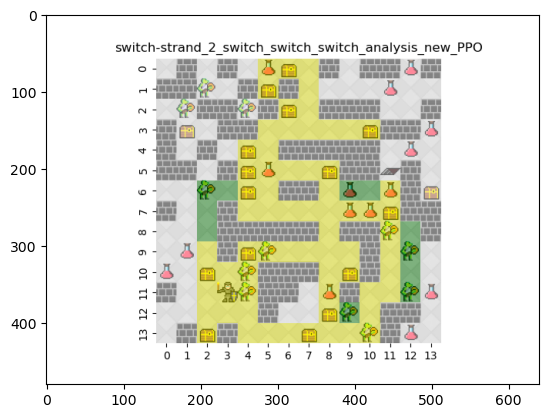

In [50]:
object_group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Potion': ['DP','SDP'],
    'Monster': ['DM'],
    'HP': ['HP']
}
group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Health': ['DP','SDP'],
    'Monster':['DM','HP']
}
basic_group = {
    'Treasure':['DT','SDT'],
    'Exit': ['DE','SDE'],
    'Health': ['DP','SDP','HP','DM'],
    # 'Monster':['DM']
}
safety_group = {
    'Treasure':['DT'],
    'Exit': ['DE'],
    'Potion': ['DP'],
    'Safe': ['SDT','SDP','SDE','HP'],
    'Monster':['DM']
}
df_shapley, pred_explain, internal, timing,MSEv,df = group_shap_single_exp(base_config,approach='empirical',group= group)
print(df['action'].unique())
#TODO look how to exclude non column
df_shapley.drop(columns = 'none',inplace=True)
fig =px.line(data_frame=df_shapley,
             x= df_shapley.index ,
             y = df_shapley.columns,
             title =f"{base_config["lvl"]} | switching agent | empirical | play-style group |  ( MSEv = {MSEv["MSEv"]['MSEv'].iloc[0]} | time(sec) = {timing["total_time_secs"]})"
             ).update_layout(xaxis_title="Step", yaxis_title="Shap Value (abs)")
fig.show()
MSEv['MSEv']
img =gen_action_map(df,f=f'./README/resources/md_stages_screenshots/md-{base_config['lvl']}-v0_step0.jpg')
plt.imshow(img)

In [17]:
df_shapley, pred_explain, internal, timing,df = group_shap_single_exp(base_config,approach='empirical',group= object_group)
print(df['action'].unique())
#TODO look how to exclude non column
df_shapley.drop(columns = 'none',inplace=True)
fig =px.line(data_frame=df_shapley.abs(),x= df_shapley.index ,y = df_shapley.columns).update_layout(xaxis_title="Step", yaxis_title="Shap Value")
fig.show()

----------Generating Data----------
{'lvl': 'policy_2', 'obs_type': 'distance', 'learning_algo': 'PPO', 'exp_type': 'switch_exitLessBetter', 'action_type': 'switch', 'action_space_type': 'discrete', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_path': 'switching', 'base_path': 'play_style_models/base/', 'which_model': 'best_model'}
switch-policy_2_switch_switch_switch_exitLessBetter_PPO


R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 2 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




0      [3.1140745]
1      [3.1140451]
2       [3.113708]
3      [3.1117535]
4      [3.0976179]
          ...     
115     [2.678426]
116    [2.6784258]
117    [1.1655737]
118    [1.1655735]
119    [1.1655732]
Name: curr_obs, Length: 120, dtype: object
['TREASURE' 'KILLER' 'POTION']


### using list of levels

In [7]:
def group_shap_lvl_analysis(lvl, base_config,approach='independence', grouping =None):
    df_gshap_list, pred_explain_list, internal_list, timing_list, df_list = [],[],[],[],[]
    configs =gen_config(lvl=lvl,algo=base_config['algo'],obs_type=base_config['obs_type'],exp_type=base_config['exp_type'],base_path= base_config['base_path'],which_model=base_config['which_model'])
    for config in configs:
        df_shapley, pred_explain, internal, timing, df = group_shap_single_exp(config=config,approach=approach, group=group)

In [74]:
print(df[['step','curr_obs','action','reward']])

     step                            curr_obs    action  reward
0       0     [12, 4, 4, 20, 20, 24, 24, 100]  TREASURE    -1.0
1       1     [11, 3, 3, 19, 19, 23, 23, 100]  TREASURE    -1.0
2       2     [10, 2, 2, 18, 18, 22, 22, 100]  TREASURE    -1.0
3       3      [9, 1, 1, 17, 17, 21, 21, 100]  TREASURE     4.0
4       4      [8, 0, 0, 16, 16, 20, 20, 100]  TREASURE    -1.0
..    ...                                 ...       ...     ...
115    19  [1000, 1000, 1000, 5, 5, 5, 5, 95]  TREASURE    -1.0
116    20  [1000, 1000, 1000, 6, 6, 4, 4, 95]  TREASURE    -1.0
117    21  [1000, 1000, 1000, 5, 5, 3, 3, 95]  TREASURE    -1.0
118    22  [1000, 1000, 1000, 4, 4, 2, 2, 95]  TREASURE    -1.0
119    23  [1000, 1000, 1000, 3, 3, 1, 1, 95]  TREASURE    19.0

[120 rows x 4 columns]


In [96]:
obs_names = ['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP']
simp_data[obs_names] =simp_data[obs_names].replace(1000,-1)
# simp_data[obs_names] =simp_data[obs_names].replace(1000,-1)

# print(simp_data)
sns.pairplot(simp_data[['DM', 'DT', 'SDT', 'DP', 'SDP', 'DE', 'SDE', 'HP','action']],hue='action')

KeyboardInterrupt: 

In [5]:
gen_groupshap_data(lvl_list,df_data,"kernel")

switch
[ 0.7375278 -1.5325549 -1.4994874  2.3702395]


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [72]:
df_train.describe()
print(torch.cuda.is_available())

False


In [32]:
model_path = 'logs/switching_analysis_1/switch-hard_killer_killer_switch_analysis_PPO/killer/best_model.zip'
model_path = 'logs/switching_analysis_1/switch-hard_treasure_treasure_switch_analysis_PPO/treasure/best_model.zip'
model_path = 'logs/switching_analysis_1/switch-hard_switch_switch_switch_analysis_PPO/switch/best_model.zip'
model_path = 'logs/switching_analysis_new/switch-hard_killer_killer_switch_analysis_killer_PPO/killer/latest_model_260000_steps.zip'


model = PPO.load(model_path, device='cpu')
print(model.policy.state_dict())

OrderedDict({'mlp_extractor.policy_net.0.weight': tensor([[-2.8711e-02,  2.3895e-01,  7.1839e-02, -8.0047e-03,  1.6270e-01,
          3.6994e-02, -1.9117e-02, -2.9320e-01],
        [-1.5817e-01, -5.7575e-02, -2.0278e-01, -4.5236e-02, -3.0052e-01,
         -8.4830e-02,  7.5421e-02,  1.9323e-02],
        [ 2.4805e-01,  3.0252e-01,  2.6052e-01,  1.0057e-01, -1.5738e-01,
         -1.9299e-01,  4.6540e-03,  3.1289e-01],
        [-2.3671e-01, -2.5660e-01, -1.3034e-01,  6.7191e-03,  5.6608e-02,
         -1.4447e-01,  8.4548e-02,  2.6592e-01],
        [-5.3237e-03,  1.6518e-01, -2.9941e-01, -2.3138e-01, -8.2819e-02,
          2.9298e-01, -3.9536e-01,  4.6884e-02],
        [-8.7504e-02, -2.0512e-01,  1.0577e-01, -8.8037e-02,  1.8560e-02,
         -1.6988e-01, -1.6097e-01, -3.1531e-02],
        [-9.4181e-02, -9.7177e-02,  1.1550e-01,  1.1941e-01,  3.4195e-02,
         -1.9690e-01,  9.2885e-02, -5.4432e-03],
        [ 2.1120e-01, -2.1161e-01, -1.8274e-02,  4.4049e-02,  1.3864e-01,
          6.714

In [51]:
lvl ='hard'
lvl_list = ['hard']
game_data, df, df_train, df_test, simp_data =gen_analysis_data(lvl_list)
configs = gen_config(lvl =lvl,algo ="PPO",obs_type="distance", exp_type="switch_analysis_killer",switch_path="switching_analysis_new/",base_path="./play_style_models/base/")
config = configs[3]
algo =config['learning_algo']
path = config['exp_path']
#seperate dataframe based on config
print(config['play_style'])
df_curr = df.loc[(df['level']== lvl) & (df['play_style']== config['play_style'])]
print(f"---------------------Groupshapley for {lvl}-{config['play_style']}-----------------")
# format data
df_train, df_test ,simp_data= prep_data(df_curr)#TODO need convert back to dataframe alos check why they are not same type as input shap

#create correct model
if config['action_type'] == "switch":
    exp = f"{config['action_type']}-{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}_{algo}"
    model_path = f"logs/{path}/{exp}/{config['play_style']}/latest_model_500000_steps.zip"
else:
    exp = f"{lvl}_{config['play_style']}_{config['reward_scheme']}_{config['exp_type']}"
    model_path = f"logs/{path}/{exp}/best_model/best_model"

if algo =="PPO":
    model = PPO.load(model_path, device='cpu')
elif config.algo =='DQN':
    model = DQN.load(model_path, device='cuda')
state_log = np.array(df_curr['curr_obs'].values.tolist())
data =torch.FloatTensor(state_log).to('cpu')


if config['obs_type']== 'grid':
    model = grid_sb3Wrapper(model)
elif algo =='PPO':
    model = sb3Wrapper(model)
elif algo == 'DQN':
    model = sb3_DQN_wrapper(model)


#tensor
dfy_train = df_curr['curr_obs'].apply(lambda x: np.max(model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32)).detach().numpy(),keepdims=True))

print(dfy_train.mean().item())
df_shapley, pred_explain, internal, timing = explain(
    model=model,
    x_train=df_train,
    x_explain=df_train.head(),
    approach='independence',
    predict_model= lambda m,x: np.max(m(torch.from_numpy(x.to_numpy()).to(float32)).detach().numpy(),keepdims=False,axis=1), #requires model and x as param
    prediction_zero=dfy_train.mean().item(),
)

# make agent model
# extract correspoding dataframe
# gen groupshap values for that config
# add to dataframe

----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'switch', 'reward_scheme': 'switch', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_switch_switch_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'hard', 'reward_scheme': 'hard', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'base_path': './play_style_models/base/'}
switch-hard_hard_hard_switch_analysis_PPO
----------Generating Data----------
{'action_type': 'switch', 'action_space_type': 'discrete', 'obs_type': 'distance', 'lvl': 'hard', 'play_style': 'treasure', 'reward_scheme': 'treasure', 'exp_type': 'switch_analysis', 'learning_algo': 'PPO', 'exp_path': 'switching_analysis/', 'ba

R[write to console]: Note: You passed a model to explain() which is not natively supported, and did not supply a 'get_model_specs' function to explain().
Consistency checks between model and data is therefore disabled.


R[write to console]: Setting parameter 'n_batches' to 3 as a fair trade-off between memory consumption and computation time.
Reducing 'n_batches' typically reduces the computation time at the cost of increased memory consumption.




<rpy2.rinterface.FloatSexpVector object at 0x7f918a3f5cd0> [14]
2


In [52]:
df_shapley

,none,DM,DT,SDT,DP,SDP,DE,SDE,HP
1,2.810186,0.003321,0.000729,0.001564,-0.002194,0.001378,-0.007106,-0.269511,-0.004172
2,2.810186,0.000602,-0.000510,-0.000835,-0.000982,0.001456,0.001551,0.082965,0.000679
3,2.810186,0.005503,-0.000269,-0.000333,0.000374,-0.001496,0.000117,0.080891,0.000140
4,2.810186,-0.000535,-0.000187,-0.000156,-0.000513,0.000519,0.001385,0.083394,0.001019
5,2.810186,0.002916,-0.000482,-0.000783,-0.000144,-0.000049,0.000975,0.081943,0.000549
